Imports

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import entropy

Helpers

In [41]:
def lorenz_curve(array):
    array = np.sort(array)
    cumulative_values = np.cumsum(array)
    cumulative_values = np.insert(cumulative_values, 0, 0)
    cumulative_values = cumulative_values / cumulative_values[-1]
    gini = 1 - 2 * np.trapezoid(cumulative_values, dx=1/len(array))
    return cumulative_values, gini


def entropy(array):
    _, counts = np.unique(array, return_counts=True)
    probabilities = counts / len(array)
    return -np.sum(probabilities * np.log2(probabilities))


Reading data from CSV

In [42]:
data = pd.read_csv('ufo-sightings.csv', sep=',', index_col=0)
data = data.dropna()
data = data.drop_duplicates()

Displaying data

In [43]:
display(data)

,Date_time,date_documented,Year,Month,Hour,Season,Country_Code,Country,Region,Locale,latitude,longitude,UFO_shape,length_of_encounter_seconds,Encounter_Duration,Description
0,1949-10-10 20:30:00,4/27/2004,1949,10,20,Autumn,USA,United States,Texas,San Marcos,29.883056,-97.941111,Cylinder,2700.0,45 minutes,This event took place in early fall around 194...
1,1949-10-10 21:00:00,12/16/2005,1949,10,21,Autumn,USA,United States,Texas,Bexar County,29.384210,-98.581082,Light,7200.0,1-2 hrs,1949 Lackland AFB&#44 TX. Lights racing acros...
2,1955-10-10 17:00:00,1/21/2008,1955,10,17,Autumn,GBR,United Kingdom,England,Chester,53.200000,-2.916667,Circle,20.0,20 seconds,Green/Orange circular disc over Chester&#44 En...
3,1956-10-10 21:00:00,1/17/2004,1956,10,21,Autumn,USA,United States,Texas,Edna,28.978333,-96.645833,Circle,20.0,1/2 hour,My older brother and twin sister were leaving ...
4,1960-10-10 20:00:00,1/22/2004,1960,10,20,Autumn,USA,United States,Hawaii,Kaneohe,21.418056,-157.803611,Light,900.0,15 minutes,AS a Marine 1st Lt. flying an FJ4B fighter/att...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80323,2013-09-09 21:15:00,9/30/2013,2013,9,21,Autumn,USA,United States,Tennessee,Nashville,36.165833,-86.784444,Light,600.0,10 minutes,Round from the distance/slowly changing colors...
80324,2013-09-09 22:00:00,9/30/2013,2013,9,22,Autumn,USA,United States,Idaho,Boise,43.613611,-116.202500,Circle,1200.0,20 minutes,Boise&#44 ID&#44 spherical&#44 20 min&#44 10 r...
80325,2013-09-09 22:00:00,9/30/2013,2013,9,22,Autumn,USA,United States,California,Napa Abajo,38.297222,-122.284444,Other,1200.0,hour,Napa UFO&#44
80326,2013-09-09 22:20:00,9/30/2013,2013,9,22,Autumn,USA,United States,Virginia,Vienna,38.901111,-77.265556,Circle,5.0,5 seconds,Saw a five gold lit cicular craft moving fastl...


Describe database

In [44]:
data.describe()

,Year,Month,Hour,latitude,longitude,length_of_encounter_seconds
count,77668.000000,77668.000000,77668.000000,77668.000000,77668.000000,7.766800e+04
mean,2003.972176,6.853608,15.554166,38.208221,-87.605826,8.055533e+03
std,10.405113,3.226473,7.731410,10.084687,37.680699,5.994055e+05
min,1910.000000,1.000000,0.000000,-46.413187,-176.658056,1.000000e-03
25%,2001.000000,4.000000,10.000000,34.147569,-112.073333,3.000000e+01
50%,2007.000000,7.000000,19.000000,39.399835,-87.924167,1.800000e+02
75%,2011.000000,9.000000,21.000000,42.732500,-78.886944,6.000000e+02
max,2014.000000,12.000000,23.000000,72.700000,178.441900,9.783600e+07


Histogram

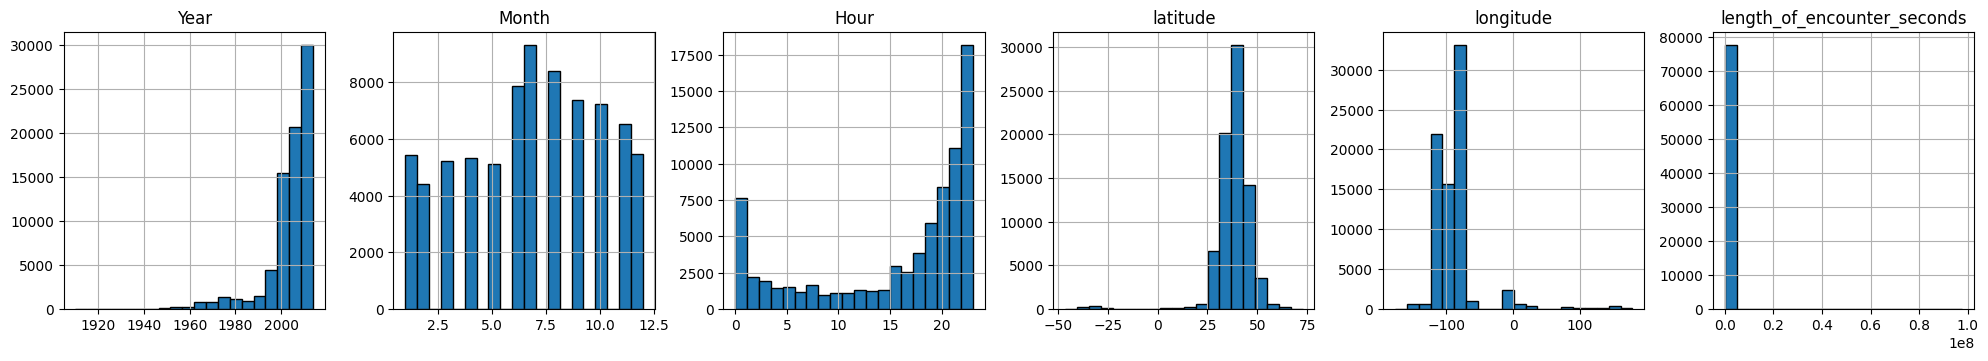

In [45]:
data.hist(figsize=(20, 20), bins=20, layout=(6, 6), edgecolor='black')
plt.tight_layout()
plt.show()

Gini index

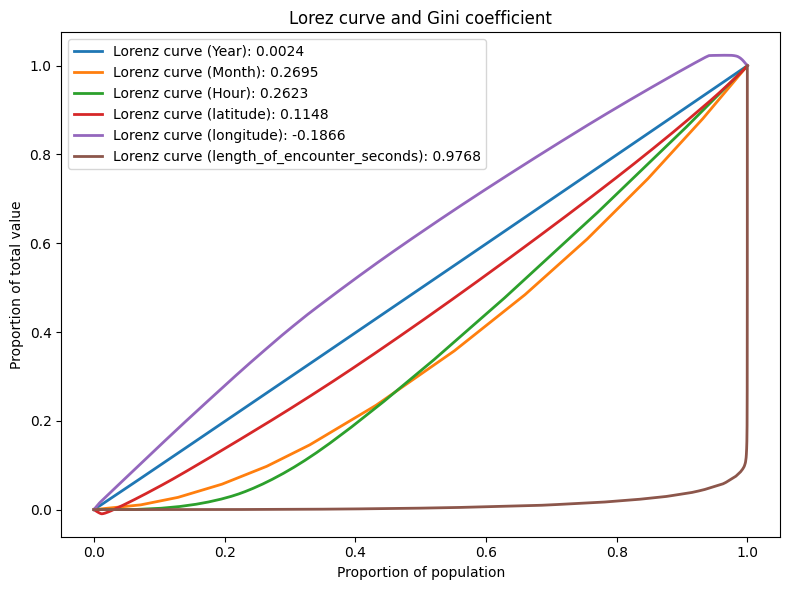

In [46]:
numeric_cols = data.select_dtypes(include=[np.number])

gini_values = {}

for col in numeric_cols.columns:
    values = numeric_cols[col].dropna().values
    cumulative_values, gini = lorenz_curve(values)
    gini_values[col] = (cumulative_values, gini)

plt.figure(figsize=(8, 6))

for col, (cumulative_values, gini) in gini_values.items():
    x_values = np.linspace(0, 1, len(cumulative_values))
    plt.plot(x_values, cumulative_values, label=f'Lorenz curve ({col}): {gini:.4f}', linewidth=2)

plt.title('Lorez curve and Gini coefficient')
plt.xlabel('Proportion of population')
plt.ylabel('Proportion of total value')
plt.legend()
plt.tight_layout()
plt.show()


Information Quantity

Entropy for Year: 4.6990
Entropy for Month: 3.5482
Entropy for Hour: 4.0509
Entropy for latitude: 12.5916
Entropy for longitude: 12.6680
Entropy for length_of_encounter_seconds: 4.9214


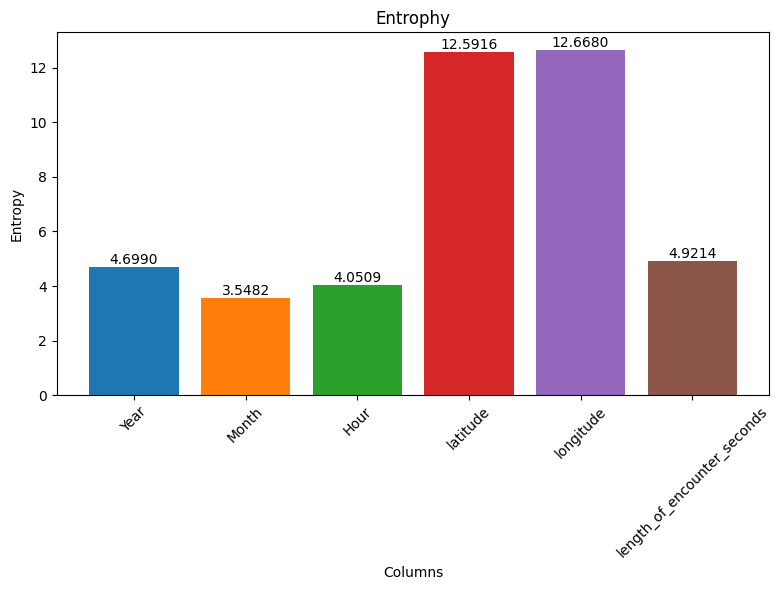

In [47]:
entropy_values = {}
for col in numeric_cols.columns:
    values = numeric_cols[col].dropna().values
    ent = entropy(values)
    entropy_values[col] = ent

plt.figure(figsize=(8, 6))
for col, ent in entropy_values.items():
    plt.bar(col, ent)
    plt.text(col, ent, f'{ent:.4f}', ha='center', va='bottom')
    print(f'Entropy for {col}: {ent:.4f}')

plt.title('Entrophy')
plt.xlabel('Columns')
plt.ylabel('Entropy')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Correlation

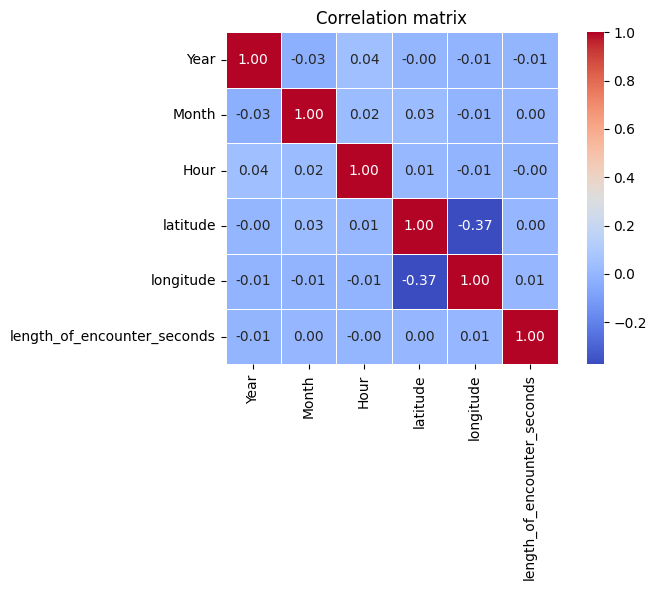

In [51]:
correlation_matrix = numeric_cols.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, square=True)

plt.title('Correlation matrix')
plt.tight_layout()
plt.show()